# Libs

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import imageio

# from enum import Enum
# from IPython.display import HTML
from typing import Callable, Tuple

from maze import generateMaze

SEED = 50
np.random.seed(SEED)

# Algorithm

In [2]:
# Position type
PosType = Tuple[float, float]

# Velocity type
VelType = Tuple[float, float]

# Memory type
MemType = Tuple[PosType, float]

# History type
HistType = Tuple[PosType, PosType, PosType, VelType]

MEM_TAL_INDEX = 0
MEM_COST_INDEX = 1

class PSO:
    def __init__(self, num_particles: int = 10, c1 = 0.5, c2 = 0.5, k: float = 0.01, p: float = 0.9, trr: float = 0.1,
                 mms: int = 10, mpr: float = 0.1, md: float = 0.1, mpp1: float = 0.1, mpp2: float = 0.1, FFthr: float = 0.0,
                 speed_limit: int = 1, speed_scaller: int = 1, spawn_point: PosType = (0, 0), spawn_radius: int = 1, 
                 cost_function: Callable = None, bubble_radius: int = 1, swarm_radius: int = 0.25, verbose=False) -> None:
        
        # Classic PSO parameters
        self.num_particles = num_particles
        self.cost_function = cost_function
        self.c1 = c1
        self.c2 = c2

        # Initializations
        self.initialize_positions(spawn_point=spawn_point, spawn_radius=spawn_radius)
        self.initialize_velocities(scaller=speed_scaller)

        # Alternative PSO parameters
        self.initialize_aor_variables(k, p, trr)
        self.initialize_mem_tool(mms, mpr, md, mpp1, mpp2, FFthr)

        # Global control variables
        cost = [self.cost_function(x) for x in self.X]
        self.gbest = self.pbest.copy()[np.argmin(cost)]

        # History for plotting
        self.initialize_history()

        # Simulation control variables
        self.speed_limit = speed_limit
        self.walls = []
        self.bubble_radius = bubble_radius
        self.swarm_radius = swarm_radius
        self.verbose = verbose

    def euclidean_distance(self, a: np.ndarray, b: np.ndarray) -> float:
        return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    
    def get_history(self) -> HistType:
        return np.array(self.X_history), np.array(self.pbest_history), np.array(self.gbest_history), np.array(self.V_history)

    def initialize_history(self) -> None:
        self.X_history = []
        self.V_history = []
        self.pbest_history = []
        self.gbest_history = []

    def initialize_positions(self, spawn_point: PosType = (0, 0), spawn_radius: int = 1,) -> None:
        self.X = np.random.rand(self.num_particles, 2) * spawn_radius + spawn_point
        self.pbest = self.X.copy()

    def initialize_velocities(self, scaller: int = 1) -> None:
        self.V = np.random.rand(self.num_particles, 2) * scaller 

    def initialize_aor_variables(self, k: float = 0.01, p: float = 0.9, trr: float = 0.1) -> None:
        # theta -> Angle of rotation (AoR)
        self.theta = np.zeros(self.num_particles, dtype=np.float16) 
        # s -> Dynamic change step for AoR
        self.s = np.array([1 if np.random.rand() > 0.5 else -1 for _ in range(self.num_particles)], dtype=np.float16)   
        # dc -> Probability of changing s each interaction
        self.dc = np.zeros(self.num_particles, dtype=np.float16)
        # temperature -> Prevent theta decreasing too quickly
        self.temperature = np.zeros(self.num_particles, dtype=np.float16)
        # Trr -> Temperature reduction rate
        self.Trr = trr

        # Constants
        self.k = k
        self.p = p

    def initialize_mem_tool(self, mms: int = 10, mpr: float = 0.1, md: float = 0.1, mpp1: float = 0.1, mpp2: float = 0.1, FFthr: float = 0.0) -> None:
        self.mem: list[list[MemType]] = [[] for _ in range(self.num_particles)]
        self.mms = mms # Maximum Memory Size
        self.mpr = mpr # Memory Point Radius
        self.md = md # Minimum Displacement
        self.mpp1 = mpp1 # Memory Point Penalty 1
        self.mpp2 = mpp2 # Memory Point Penalty 2
        self.FFthr = FFthr # Threshold

    def has_collision_with_particle(self, pos: tuple[int, int]) -> bool:
        for _, agent in enumerate(self.X):
            if np.linalg.norm(agent - pos) < self.swarm_radius:
                return True
        return False
    
    def has_collision_with_wall(self, pos: tuple[int, int]) -> bool:
        bubble = (pos[0], pos[1], self.bubble_radius, self.bubble_radius)
        for wall in self.walls:
            # if pos[0] > wall[0] and pos[0] < wall[0] + wall[2] and pos[1] > wall[1] and pos[1] < wall[1] + wall[3]:
            #     return True
            if bubble[0] < wall[0] + wall[2] and bubble[0] + bubble[2] > wall[0] \
                and bubble[1] < wall[1] + wall[3] and bubble[1] + bubble[3] > wall[1]:
                return True
        return False
    
    def update_theta(self, index) -> np.ndarray:
        # Update velocity using AoR concept [7]
        RV = [[np.cos(self.theta[index]), -np.sin(self.theta[index])], [np.sin(self.theta[index]), np.cos(self.theta[index])]]
        RV = np.matmul(RV, self.V[index])

        # Update theta with temperature [8]
        self.theta[index] = self.temperature[index] * self.theta[index]

        # Update temperature [9]
        self.temperature[index] = self.Trr * self.temperature[index]

        return RV

    def evaluate_position(self, index: int = None) -> None:
        # Reduce ν for τ near to Pit1 inside the Memoryit by MPP2  
        if len(self.mem[index]) > 0 and self.md > self.euclidean_distance(self.X[index], self.mem[index][-1][MEM_TAL_INDEX]):
            self.mem[index][-1][MEM_COST_INDEX] -= self.mpp2

    def update_memory(self, index: int = None) -> None:
        if index is None:
            return
        
        current_position = self.pbest[index]
        
        # If a particle memory is empty, then start it
        if 0 == len(self.mem[index]):
            self.mem[index].append([current_position, self.cost_function(current_position)])
            return
        
        # For each memory registered in the memory of a particle
        for i in range(len(self.mem[index])):

            # Take the τ and ν from the memory
            tal, val = self.mem[index][i]
            
            # if Pbest distance to any τ in the memory is less than MPR
            distance = self.euclidean_distance(current_position, tal)
            if distance < self.mpr:
                # Reduce corresponding ν inside the Memory by MPP1
                self.mem[index][i][1] = val - self.mpp1

                # Select the pair with maximun ν from the memory and set its τ as Pit
                # TODO: Test with minimum value.
                best_cost_index = np.argmax(self.mem[index][i][:][1])
                self.mem[index][best_cost_index][MEM_TAL_INDEX] = current_position
            else:
                # if size of Memory i > MMS then 
                if len(self.mem[index]) > self.mms:
                    # Remove the oldest Memory i member
                    self.mem[index].pop(0)

                # Insert new xi into Memory i
                self.mem[index].append([current_position, self.cost_function(current_position)])

    def evaluate_bests(self, index: int = None, epoch: int = 0) -> None:
        if index is None:
            return
        
        pbest_cost = self.cost_function(self.pbest[index])
        local_cost = self.cost_function(self.X[index])

        # Current x has better fitness than pbest
        if local_cost < pbest_cost:
            # Update the set of Personal-Bests it with P it
            self.pbest[index] = self.X.copy()[index]
            # print(f"Epoch {epoch}. Personal best improved. Cost: {self.cost_function(self.pbest[index]):.2f} Pos: {self.pbest[index]}")

            self.update_memory(index)
         
            # Select the best element of Personal-Bests it as G i
            global_cost = self.cost_function(self.gbest)
            if pbest_cost < global_cost:
                if self.verbose:
                    print(f"Epoch {epoch}. Global best improved. Cost: {self.cost_function(self.gbest):.2f} Pos: {self.gbest}")
                self.gbest = self.pbest[index]

    def update_velocity(self, index, n1=1.0, n2=1.0) -> None:
        # Randomly set r1 and r2
        r1 = np.random.rand()
        r2 = np.random.rand()

        # Update velocity as classic PSO [2]
        self.V[index] = self.V[index] + self.c1 * n1 * r1 * (self.pbest[index] - self.X[index]) + self.c2 * n2* r2 * (self.gbest - self.X[index])

        # Limit velocity between arbitrary limits
        if np.abs(self.V[index][0]) > self.speed_limit:
            self.V[index][0] = np.sign(self.V[index][0])
        if np.abs(self.V[index][1]) > self.speed_limit:
            self.V[index][1] = np.sign(self.V[index][1])

    def update_movement(self, index, RV=(0, 0)) -> None:
        next_pos = self.X[index] + RV

        if self.has_collision_with_wall(next_pos) or self.has_collision_with_particle(next_pos):
            # Change theta [4]
            self.theta[index] += self.s[index]

            # Set temperature to maximun
            self.temperature[index] = 1.0

            # Increase Dc [5]
            self.dc[index] += self.k

            # Randomly modify s and dc (Maybe add a scaller here)
            if np.random.rand() < self.dc[index]:
                self.s[index] *= -1
                self.dc[index] = 0.0

            next_pos = self.X[index]
        else:
            # Decrease dc [6]
            self.dc[index] *= self.p

        self.X[index] = next_pos

    def register_history(self) -> None:
        self.X_history.append(self.X.copy())
        self.V_history.append(self.V.copy())
        self.pbest_history.append(self.pbest.copy())
        self.gbest_history.append(self.gbest)

    def run(self, epochs: int = 300, end_condition_checker: Callable = None, timeout_epochs: int = 1000) -> None:      
        try:
            MAX_EPOCHS = timeout_epochs
            while epochs or end_condition_checker is not None:
                counter = epochs if end_condition_checker is None else MAX_EPOCHS-timeout_epochs

                for i in range(self.num_particles):
                    # Update only if the particle is not near the goal
                    if self.cost_function(self.X[i]) < 1.0:
                        continue
                    
                    RV = self.update_theta(i)
                    self.evaluate_position(i)
                    self.evaluate_bests(i, counter)
                    
                    n1 = 1 if self.cost_function(self.pbest[i]) > self.FFthr else 0
                    n2 = 1 if self.cost_function(self.gbest) > self.FFthr else 0

                    if n1 == 0 and n2 == 0:
                        self.mem: list[list[MemType]] = [[] for _ in range(self.num_particles)]
                    else:
                        self.update_velocity(i, n1, n2)

                    self.update_movement(i, RV)

                self.register_history()

                if end_condition_checker is not None and end_condition_checker(self.gbest, self.pbest):
                    print(f"End condition reached in {counter} epochs. Best cost: {self.cost_function(self.gbest)}")
                    break
                elif end_condition_checker is None:
                    epochs -= 1
                elif end_condition_checker is not None and timeout_epochs > 0:
                    timeout_epochs -= 1
                elif timeout_epochs == 0:
                    print(f"Timeout reached in {counter} epochs. Best cost: {self.cost_function(self.gbest)}")
                    break
                
        except KeyboardInterrupt:
            print("Stopped by user")

    def animate(self, i):
        X_history, pbest_history, gbest_history, V_history = self.get_history()
        if i > len(X_history):
            return [*self.X_plots, *self.pbest_plots, *self.V_plots, self.gbest_plot]
        
        if X_history is None:
            raise Exception("Run simulation first")
        
        for j in range(len(self.X_plots)):
            self.X_plots[j].set_offsets(X_history[i][j])
            self.V_plots[j].set_offsets(X_history[i][j])
            self.V_plots[j].set_UVC(V_history[i][j][0], V_history[i][j][1])

        for j in range(len(self.pbest_plots)):
            self.pbest_plots[j].set_offsets(pbest_history[i][j])

        self.gbest_plot.set_offsets(gbest_history[i])

        self.plot_title.set_text(f"PSO Epoch: {i}")
        
        return [*self.X_plots, *self.pbest_plots, *self.V_plots, self.gbest_plot]

    def plot(self, ax: plt.Axes) -> None:
        self.plot_title = ax.set_title("PSO")
        ax.grid(visible=True, which='both', axis='both', color='gray', linestyle='--')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        for wall in self.walls:
           ax.add_patch(plt.Rectangle((wall[0], wall[1]), wall[2], wall[3], color='black', fill=True, alpha=0.5))
        
        pbest_list = self.get_history()[1][0]
        X_list = self.get_history()[0][0]
        gbest = self.get_history()[2][0]
        V_list = self.get_history()[3][0]

        self.X_plots = [
            ax.scatter(x[0], x[1], color='blue', marker='o') for x in X_list
        ]
        
        self.V_plots = [
            ax.quiver(x[0], x[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, width=0.005, alpha=0.3) for x, v in zip(X_list, V_list)
        ]
        
        self.pbest_plots = [
            ax.scatter(pbest[0], pbest[1], color='orange', marker='x', alpha=0.5) for pbest in pbest_list
        ]

        self.gbest_plot = ax.scatter(gbest[0], gbest[1], color='green', marker='x')

    def display(self, fig: plt.Figure, ax: plt.Axes, interval: int = 100) -> None:
        self.plot(ax)

        anim = animation.FuncAnimation(
            fig,
            self.animate,
            frames=len(self.X_history),
            interval=interval,
            blit=True
        )

        return anim
    
    def add_virtual_wall(self, x, y, width, height) -> None:
        self.walls.append((x, y, width, height))

# Map generation

In [3]:
WALL = 0
WALL_WIDTH = 1

def create_map(add_virtual_wall: Callable, shape: tuple[int, int] = (50, 50), maze: np.ndarray = None) -> None:
    width = shape[0] if maze is None else maze.shape[0]
    height = shape[1] if maze is None else maze.shape[1]

    surrounding_walls = 5
    # Surrounding the maze with walls
    add_virtual_wall(-surrounding_walls, -surrounding_walls, width + surrounding_walls*2, surrounding_walls)
    add_virtual_wall(-surrounding_walls, -surrounding_walls, surrounding_walls, height+surrounding_walls*2)
    add_virtual_wall(-surrounding_walls, height, width + surrounding_walls*2, surrounding_walls)
    add_virtual_wall(width, -surrounding_walls, surrounding_walls, height+surrounding_walls*2)

    if maze is None:
        maze = generateMaze(width, height, SEED)

    for i in range(width):
        for j in range(shape[1]):
            if maze[i, j] == WALL:
                add_virtual_wall(i, j, 1, 1)

    return maze

def generateOneWallMap(add_virtual_wall: Callable = None, shape: tuple[int, int] = (10, 10), maze: np.ndarray = None) -> None:
    assert shape[0] > 3
    assert shape[1] > 3

    if maze is None:
        maze = np.ones(shape, dtype=np.uint8)

    # Add only one wall in the middle
    x = 1
    w = int(shape[0] - 2)
    h = 2 if shape[1] % 2 == 0 else 3
    y = int(shape[1] / 2 if shape[1] % 2 == 0 else (shape[1] - 2) / 2)

    maze[x:x+w, y:y+h] = WALL

    if add_virtual_wall is not None:
        for i in range(shape[0]):
            for j in range(shape[1]):
                if maze[i, j] == WALL:
                    add_virtual_wall(i, j, 1, 1)

    return maze


In [8]:
MAP_WIDTH = 21
MAP_HEIGHT = 21
START_POINT = (1, 1)

maze = generateMaze(MAP_WIDTH, MAP_HEIGHT, SEED, start_point=START_POINT)
# maze = generateOneWallMap(add_virtual_wall=None, shape=(MAP_WIDTH, MAP_HEIGHT), maze=None)

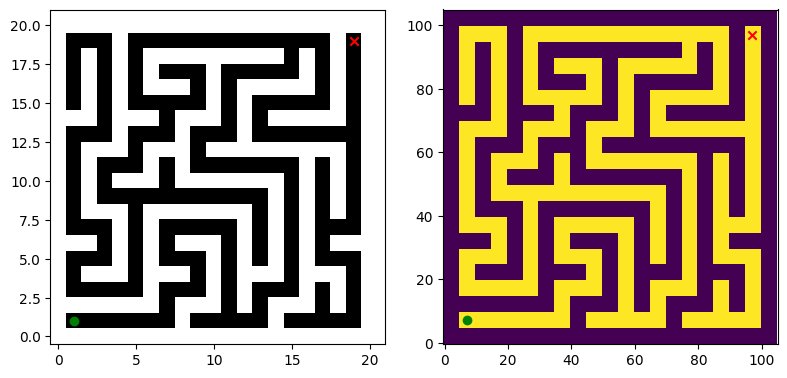

In [27]:
SCALE_INDEX = 5
bigger_maze = np.ones(((MAP_WIDTH)*SCALE_INDEX, (MAP_HEIGHT)*SCALE_INDEX), dtype=np.uint8)
TARGET = (19, 19)
TARGET_SCALED = (TARGET[0]*SCALE_INDEX+((SCALE_INDEX-1)/2), TARGET[1]*SCALE_INDEX+((SCALE_INDEX-1)/2))
START_POINT_SCALLED = (START_POINT[0]*SCALE_INDEX+((SCALE_INDEX-1)/2), START_POINT[1]*SCALE_INDEX+((SCALE_INDEX-1)/2))

for i in range(MAP_WIDTH):
    for j in range(MAP_HEIGHT):
        if maze[i, j] == 0:
            bigger_maze[i*SCALE_INDEX:(i+1)*SCALE_INDEX, j*SCALE_INDEX:(j+1)*SCALE_INDEX] = 0

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 8))

fig.tight_layout()

axs[0].imshow(maze.T, cmap='binary')
axs[0].set_xlim(-0.5, MAP_WIDTH)
axs[0].set_ylim(-0.5, MAP_HEIGHT)
axs[0].scatter(TARGET[0], TARGET[1], marker='x', color='red')
axs[0].scatter(START_POINT[1], START_POINT[1], marker='o', color='green')

axs[1].imshow(bigger_maze.T, cmap='viridis')
axs[1].set_xlim(-0.5, (MAP_WIDTH)*SCALE_INDEX)
axs[1].set_ylim(-0.5, (MAP_HEIGHT)*SCALE_INDEX)
axs[1].scatter(TARGET_SCALED[0], TARGET_SCALED[1], marker='x', color='red')
axs[1].scatter(START_POINT_SCALLED[0], START_POINT_SCALLED[1], marker='o', color='green')

plt.show()

# Simulation

In [32]:
MAP = bigger_maze
start = START_POINT_SCALLED
width = MAP.shape[0]
height = MAP.shape[1]
target = TARGET_SCALED

COST_TARGET = 0.5
NUM_PARTICLES = 10

def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def cost_function(X: np.ndarray) -> float:
    return euclidean_distance(X, target)

def end_condition(gbest: np.ndarray, pbest: np.ndarray) -> bool:
    gbest_contition = cost_function(gbest) < COST_TARGET
    costs = np.array([cost_function(x) for x in pbest], dtype=np.float16)
    pbest_condition = np.count_nonzero(costs < COST_TARGET) >= NUM_PARTICLES

    return gbest_contition and pbest_condition

# C1, C2 are the cognitive and social constants
# 's' is the direction of the particle (-1 and 1)
# Dc is the probability of changing s
# k intertial constant for Dc
# p Reduction constant for Dc
# Trr is the temperature reduction rate
SWARM_RADIUS = width/100
parameters = {
    'num_particles': NUM_PARTICLES,
    'c1': 1.0,
    'c2': 1.5,
    'k': 0.01,
    'p': 0.9,
    'trr': 0.9,
    'mpr': 2*SWARM_RADIUS,
    'mms': 3,
    'md': 3.5,
    'mpp1': 0.9,
    'mpp2': 0.4,
    'spawn_point': start,
    'spawn_radius': 1,
    'speed_scaller': 0.005,
    'cost_function': cost_function,
    'bubble_radius': 0.001,
    'swarm_radius': SWARM_RADIUS,
    'speed_limit': 0.001
}
pso = PSO(**parameters)

mapa = create_map(pso.add_virtual_wall, maze=MAP, shape=MAP.shape)

In [33]:
pso.run(end_condition_checker=end_condition, timeout_epochs=5000)

best_cost = [cost_function(x) for x in pso.X]
best_index = np.argmin(best_cost)

print(f"Best particle cost: {best_cost[best_index]}")
print(f"Best particle position: {pso.X[best_index]}")

Timeout reached in 5000 epochs. Best cost: 36.50212367524946
Best particle cost: 49.610598851203235
Best particle position: [77.10620046 51.55279702]


# Optimizer

In [24]:
from sklearn.model_selection import ParameterGrid

SWARM_RADIUS = width/100
parameters = {
    'num_particles': [NUM_PARTICLES, NUM_PARTICLES*2],
    'c1': np.arange(0.2, 1.0, 0.2),
    'c2': [1.5],
    'k': [0.01],
    'p': [0.9],
    'trr': [0.9],
    'mpr': [2*SWARM_RADIUS],
    'mms': [3],
    'md': [3.5],
    'mpp1': [0.9],
    'mpp2': [0.4],
    'spawn_point': [start],
    'spawn_radius': [1],
    'speed_scaller': [0.005],
    'cost_function': [cost_function],
    'bubble_radius': [0.01],
    'swarm_radius': [SWARM_RADIUS],
    'speed_limit': [0.001],
    'verbose': [False]
}

parameter_grid = ParameterGrid(parameters)

results = []

for params in parameter_grid:
    pso = PSO(**params)
    pso.run(end_condition_checker=end_condition, timeout_epochs=1000)

    best_cost = [cost_function(x) for x in pso.X]
    best_index = np.argmin(best_cost)

    num_particles_near_target = np.count_nonzero(np.array([cost_function(x) for x in pso.X]) < COST_TARGET)

    results.append({
        'num_particles_near_target': num_particles_near_target,
        'parmas': params,
        'pbest': pso.pbest,
    })

    print(f"Best particle cost: {best_cost[best_index]}")
    print(f"Best particle position: {pso.X[best_index]}")
    print("-------")

results.sort(key=lambda x: x['num_particles_near_target'], reverse=True)

Timeout reached in 1000 epochs. Best cost: 1.1184744898399581
Best particle cost: 0.844836607731686
Best particle position: [97.72097748 96.55961339]
-------
Timeout reached in 1000 epochs. Best cost: 1.3508984918544549
Best particle cost: 0.6539504612894591
Best particle position: [96.36294269 97.14767934]
-------
Timeout reached in 1000 epochs. Best cost: 1.1249957501126033
Best particle cost: 0.41112722697957327
Best particle position: [96.61794854 96.84813731]
-------
Timeout reached in 1000 epochs. Best cost: 1.1871321030686706
Best particle cost: 0.4326605525871948
Best particle position: [96.7691564  97.36593222]
-------
Timeout reached in 1000 epochs. Best cost: 1.156987906595204
Best particle cost: 0.3037821500865953
Best particle position: [96.83814353 97.25707213]
-------
Timeout reached in 1000 epochs. Best cost: 1.2102577417436327
Best particle cost: 0.47001994698730476
Best particle position: [96.973694   96.53071678]
-------
Timeout reached in 1000 epochs. Best cost: 1.3

In [25]:
best_result = results[0]

print(f"Particles near target: {best_result['num_particles_near_target']}")
print(f"Best parameters: {best_result['parmas']}")

pso = PSO(**best_result['parmas'])
pso.run(end_condition_checker=end_condition, timeout_epochs=1000)

Particles near target: 1
Best parameters: {'bubble_radius': 0.01, 'c1': np.float64(0.4), 'c2': 1.5, 'cost_function': <function cost_function at 0x7fa36cf3bac0>, 'k': 0.01, 'md': 3.5, 'mms': 3, 'mpp1': 0.9, 'mpp2': 0.4, 'mpr': 2.1, 'num_particles': 10, 'p': 0.9, 'spawn_point': (7.0, 7.0), 'spawn_radius': 1, 'speed_limit': 0.001, 'speed_scaller': 0.005, 'swarm_radius': 1.05, 'trr': 0.9, 'verbose': False}
Timeout reached in 1000 epochs. Best cost: 1.0666733987675698


# Creating GIF

In [30]:
def make_video(history: list[HistType], secods: int = 10) -> None:

    writer = imageio.get_writer('./cost_map.gif', mode='I')
    X_history, pbest_history, gbest_history, V_history = history

    padding = 10
    for step in range(len(X_history)):
        # Create cost map
        cost_map = np.zeros((width, height, 1), dtype=np.uint8)
        for i in range(width):
            for j in range(height):
                cost_map[i, j] = np.uint8(np.abs(euclidean_distance(np.array([i, j]), (target[1], target[0]))))

        # Create frame
        frame = cv2.cvtColor(cost_map, cv2.COLOR_GRAY2RGB)

        # Add walls
        for i in range(width):
            for j in range(height):
                if MAP[i, j] == 0:
                    frame = cv2.rectangle(frame, (i, j), (i+1, j+1), (255, 255, 0), 1, 1)
                
        # Add target marker
        frame = cv2.drawMarker(frame, (int(target[0]), int(target[1])), (127, 127, 127), cv2.MARKER_CROSS, 1, 1)
        
        # Add title
        frame = cv2.putText(frame, f"{step}", (int(width/2) - padding, SCALE_INDEX), 
                            cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.4, (0, 0, 0), 1, cv2.LINE_AA
        )

        # Resize frame, apply colormap
        frame = cv2.resize(frame, (width, height))
        frame = cv2.applyColorMap(frame, cv2.COLORMAP_INFERNO)

        if step > len(X_history):
            break
        
        for partile in range(NUM_PARTICLES):
            # Add particle position
            frame = cv2.circle(frame, (int(X_history[step][partile][0]), int(X_history[step][partile][1])), 0, (255, 0, 0), 1)

            # Add particle velocity arrow
            start_pos = np.array(X_history[step][partile], dtype=np.int16)
            # frame = cv2.arrowedLine(frame, 
            #                         start_pos, # Start Point
            #                         start_pos + np.array(V_history[step][partile], dtype=np.int16), # End Point
            #                         (100, 100, 100), # Color
            #                         1 # thickness
            # )

        # for j in range(len(self.pbest_plots)):
        #     self.pbest_plots[j].set_offsets(pbest_history[i][j])

        frame = cv2.drawMarker(frame, (int(gbest_history[i][0]), int(gbest_history[i][1])), (127, 255, 56), cv2.MARKER_CROSS, 1, 1)

        # time.sleep(0.5)
        writer.append_data(frame)

make_video(pso.get_history(), secods=5)

# Creating GIF with MATPLOTLIB (Too lazy)

In [95]:
cost_map = np.ones((width, height))

for i in range(width):
    for j in range(height):
        cost_map[i, j] = euclidean_distance(np.array([i, j]), target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(target[0], target[1], color='red', marker='x')
ax.scatter(start[0], start[1], color='green', marker='o')
ax.set_xlim(-10, height + 10)
ax.set_ylim(-10, width + 10)
ax.imshow(cost_map, cmap='magma', interpolation='nearest', alpha=0.5)

# pso.plot(ax)
# plt.savefig('pso.png')

anim = pso.display(fig, ax, interval=10)
anim.save('pso.gif', writer='pillow')

plt.show()